In [12]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
import matplotlib.patches as patches
from pathlib import Path
import re

In [13]:

# ---- grids / mappings ----
NUM_SPACING = 29          # adjust if needed
NUM_WIDTH   = 10

spacing_um = np.linspace(2.0, 30.0, NUM_SPACING)   # 0→2 µm, 28→30 µm
width_um   = np.linspace(1.0, 10.0, NUM_WIDTH)     # 0→1 µm, 9→10 µm
doping_map = {
    0: "intrinsic",
    1: "1e15 cm^-3",
    2: "1e16 cm^-3",
    3: "1e17 cm^-3",
}
mode_map = {0: "A0", 1: "S0"}

def load_measure(path, value_name):
    # CSV has no header; five columns as described
    df = pd.read_csv(path, header=None, names=[
        "spacing_idx", "width_idx", "doping_idx", "mode_idx", value_name
    ])
    # attach physical labels (keep indices too)
    df["spacing_um"] = df["spacing_idx"].map({i:v for i,v in enumerate(spacing_um)})
    df["width_um"]   = df["width_idx"].map({i:v for i,v in enumerate(width_um)})
    df["doping"]     = df["doping_idx"].map(doping_map)
    df["mode"]       = df["mode_idx"].map(mode_map)
    return df

# Examples:
Qdf     = load_measure("./data/Q.csv",     "Q")
fdf     = load_measure("./data/freq.csv",  "freq_Hz")
eg_ksq1_df = load_measure("./data/eg_ksq1.csv", "eg_ksq1")   # unitless (e.g., 0.006 = 0.6%)
eg_ksq2_df = load_measure("./data/eg_ksq2.csv", "eg_ksq2")   # unitless (e.g., 0.006 = 0.6%)
k2fd_df = load_measure("./data/k2_fd.csv", "k2_fd")
Lm_df   = load_measure("./data/Lm.csv",    "Lm_H")
Rm_df   = load_measure("./data/Rm.csv",    "Rm_ohm")
Cm_df   = load_measure("./data/Cm.csv",    "Cm_F")

# sanity peek
Qdf.head(10)
k2fd_df.count()
Qdf.count()

spacing_idx    2320
width_idx      2320
doping_idx     2320
mode_idx       2320
Q                31
spacing_um     2320
width_um       2320
doping         2320
mode           2320
dtype: int64

In [14]:
keys = ["spacing_idx","width_idx","doping_idx","mode_idx","spacing_um","width_um"]
df = (Qdf[keys+["Q"]]
      .merge(fdf[keys+["freq_Hz"]],   on=keys, how="inner")
      .merge(eg_ksq1_df[keys+["eg_ksq1"]], on=keys, how="inner")
      .merge(eg_ksq2_df[keys+["eg_ksq2"]], on=keys, how="inner")
     .merge(k2fd_df[keys+["k2_fd"]],   on=keys, how="inner"))
# then use the plotting code from the merged-df section
df.head()

,spacing_idx,width_idx,doping_idx,mode_idx,spacing_um,width_um,Q,freq_Hz,eg_ksq1,eg_ksq2,k2_fd
0,0,0,0,0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,0,0,0,1,2.0,1.0,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
3,0,0,1,1,2.0,1.0,NaN,NaN,NaN,NaN,NaN
4,0,0,2,0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [15]:
undamped_data = {
    "lambda": [7.000E-06,8.000E-06,9.000E-06,1.000E-05,1.100E-05,1.200E-05,1.300E-05,1.400E-05,1.50E-05,1.60E-05,2.00E-05,2.60E-05,4.00E-05,8.00E-05],
    "hGan/Lambda": [0.63, 0.55, 0.49, 0.440, 0.400, 0.367, 0.338,0.314,0.293,0.275,0.220,0.169, .110,.055],
    "Antisymmetric ksq%": [0.055, 0.081, 0.103, 0.121, 0.134, 0.143, 0.148,0.150 ,0.152,0.149, 0.134,0.105,.064,.031],
    "Symmetric ksq%": [0.275, 0.358, 0.448, 0.533, 0.602, 0.643, 0.652,0.641,0.624,0.604,.56,.552,0.567,.576]
}
undamped_df = pd.DataFrame(undamped_data)

Gather k^2 entries where spacing and width track closest to $\lambda/4$ (spacing equals width). This enables comparison of new app data to Fig-3-4 of Popa Thesis where the geometry is contrained 

In [16]:
# Gather k^2 entries where spacing and width track closest to \lambda/4 (spacing approximately equals width).
hGaN_um   = 4.4
width_sel = 2.0
Nd_idx    = 1          # 1e15 cm^-3
modes     = {0:"A0", 1:"S0"}
style     = {0:"--",  1:"-"}   # A0 dashed, S0 solid
closest_lambda_quarter = df[(df['k2_fd'].notna()) & (df['doping_idx'] == Nd_idx)].copy()
closest_lambda_quarter['lambda_um'] = 2.0 * (closest_lambda_quarter['spacing_um'] + closest_lambda_quarter['width_um'])
closest_lambda_quarter['hGaN/lambda'] = hGaN_um / closest_lambda_quarter['lambda_um']
closest_lambda_quarter['width_spacing_err'] = (closest_lambda_quarter['width_um'] - closest_lambda_quarter['spacing_um']).abs()

min_err = closest_lambda_quarter['width_spacing_err'].min()
mode_label_map = {0: 'ksq_A0', 1: 'ksq_S0'}
lambda_quarter_df = (
    closest_lambda_quarter[closest_lambda_quarter['width_spacing_err'] == min_err]
    .assign(mode_label=lambda frame: frame['mode_idx'].map(mode_label_map))
    .pivot_table(index='hGaN/lambda', columns='mode_label', values='k2_fd', aggfunc='first')
    .reset_index()
    .reindex(columns=['hGaN/lambda', 'ksq_A0', 'ksq_S0'])
    .dropna(subset=['ksq_A0', 'ksq_S0'])
    .sort_values('hGaN/lambda')
)

lambda_quarter_df
#to do: add width and spacing columns

mode_label,hGaN/lambda,ksq_A0,ksq_S0
1,0.183333,0.208157,0.622492
2,0.220000,0.220165,0.653558
3,0.275000,0.238181,0.734724
4,0.366667,0.261010,0.838479
5,0.550000,0.325907,0.694543


Text(0, 0.5, '$k^2$ [%]')

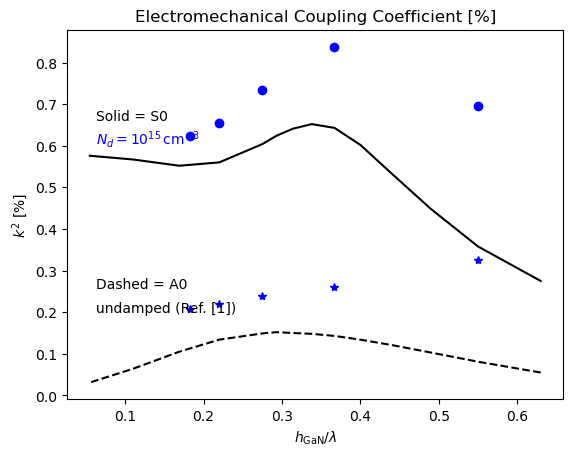

In [17]:


# keep only the relevant slice
dfA0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()

# NaN/Inf guard for each plot
df_k2_A0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
df_k2_S0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
df_k2_A0["lambda_um"]     = 2.0*(df_k2_A0["spacing_um"] + df_k2_A0["width_um"])
df_k2_A0['hGaN/lambda'] = hGaN_um / df_k2_A0["lambda_um"]
df_k2_S0["lambda_um"]     = 2.0*(df_k2_S0["spacing_um"] + df_k2_S0["width_um"])
df_k2_S0['hGaN/lambda'] = hGaN_um / df_k2_S0["lambda_um"]
fig, ax = plt.subplots()

# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid

ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq_A0"], color='b', linestyle='none', marker='*')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq_S0"], color='b', linestyle='none', marker='o')#, label = r'$k^2 [\%]$')

ax.plot(undamped_df["hGan/Lambda"], undamped_df["Antisymmetric ksq%"], color='k', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(undamped_df["hGan/Lambda"], undamped_df["Symmetric ksq%"], color='k', linestyle='-')#, label = r'$k^2 [\%]$')
# Annotations
# Nd annotations in figure coordinates (left, midway up)

ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.15, 0.65), xycoords='figure fraction', color='b', fontsize=10)
ax.annotate('undamped (Ref. [1])', xy=(0.15, 0.3), xycoords='figure fraction', color='k', fontsize=10)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%]')
ax.set_ylabel(r'$k^2$ [%]')

Old plot for comparison 

Note this was with geometry that always had width = $\lambda / 4 $

<img src="SavedFigs/ksq_wdth_lmbdaOver_4.png" alt="Test setup" width="420">



### check eigenmode $k^2$ (kind of works)

Text(0, 0.5, '$k^2$ [%]')

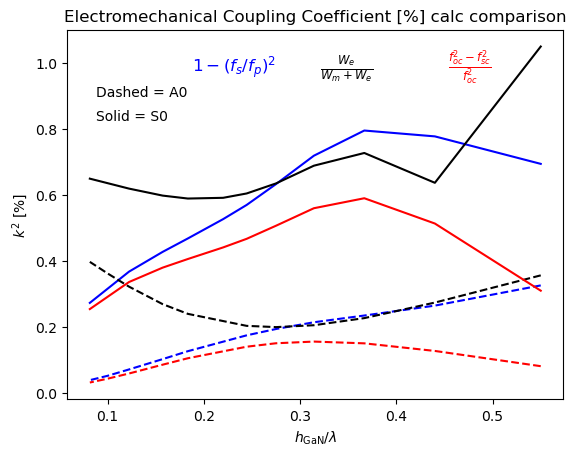

In [31]:

# NaN/Inf guard for each plot
df_k2_A0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
df_k2_S0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
df_k2_A0["lambda_um"]     = 2.0*(df_k2_A0["spacing_um"] + df_k2_A0["width_um"])
df_k2_A0['hGaN/lambda'] = hGaN_um / df_k2_A0["lambda_um"]
df_k2_S0["lambda_um"]     = 2.0*(df_k2_S0["spacing_um"] + df_k2_S0["width_um"])
df_k2_S0['hGaN/lambda'] = hGaN_um / df_k2_S0["lambda_um"]


fig, ax = plt.subplots()
# curves of Nd = 1e16 are red, with red text stating Nd = 1e16
#curves of Nd = 1e15 are blue, with blue text stating Nd = 1e15
# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid

ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['k2_fd'], color='b', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['k2_fd'], color='b', linestyle='-')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['eg_ksq1'], color='k', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['eg_ksq1'], color='k', linestyle='-')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['eg_ksq2'], color='r', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['eg_ksq2'], color='r', linestyle='-')#, label = r'$k^2 [\%]$')
# Annotations
# Nd annotations in figure coordinates (left, midway up)

ax.annotate(r'$1-(f_s/f_p)^2$', xy=(0.3, 0.8), xycoords='figure fraction', color='b', fontsize=12)
ax.annotate(r'$\frac{W_e}{W_m+W_e}$', xy=(0.5, 0.8), xycoords='figure fraction', color='k', fontsize=12)
ax.annotate(r'$\frac{f_{oc}^2 - f_{sc}^2}{f_{oc}^2}$', xy=(0.7, 0.8), xycoords='figure fraction', color='r', fontsize=12)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)


ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%] calc comparison')
ax.set_ylabel(r'$k^2$ [%]')

### plot $f\cdot Q$ product for $N_d = 10^{15}$ at width = $2\mu m$ 

(1.0, 4.0)

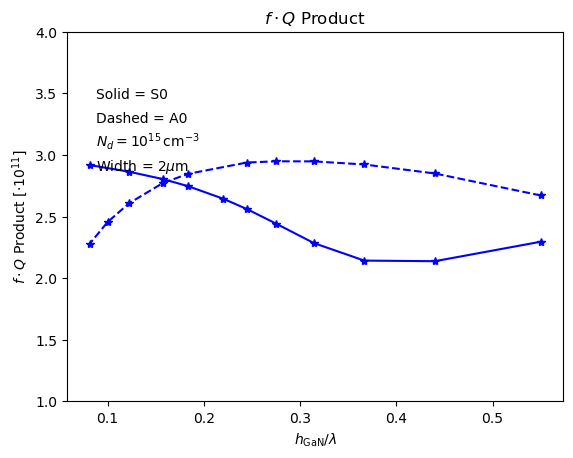

In [37]:
#dfA0 = df[(df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
#dfS0 = df[(df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()
width_sel = 2.0
dfA0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()
# NaN/Inf guard for each plot
df_Q_A0 = dfA0[np.isfinite(dfA0['Q'])].copy()
df_Q_S0 = dfS0[np.isfinite(dfS0['Q'])].copy()
# derive axes
df_Q_A0["lambda_um"]     = 2.0*(df_Q_A0["spacing_um"] + df_Q_A0["width_um"])
df_Q_A0['hGaN/lambda'] = hGaN_um / df_Q_A0["lambda_um"]
df_Q_S0["lambda_um"]     = 2.0*(df_Q_S0["spacing_um"] + df_Q_S0["width_um"])
df_Q_S0['hGaN/lambda'] = hGaN_um / df_Q_S0["lambda_um"]
# Plot material best-case using Popa Figure 5-24 
# acoustive velcity = 7990 m/s, f = v/λ, fQ = 2*10^13
# hGaN / lambda = hGaN *f/v 
# # f = the range over the data we have 
f1 = df_Q_A0['freq_Hz'].min()
f2 = df_Q_A0['freq_Hz'].max()
v = 7990 
hGaN = 4.4e-6

fig, ax = plt.subplots()
# curves of Nd = 1e16 are red, with red text stating Nd = 1e16
#curves of Nd = 1e15 are blue, with blue text stating Nd = 1e15
# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid
ax.plot(df_Q_A0['hGaN/lambda'], df_Q_A0['Q']*df_Q_A0['freq_Hz']/1e11, color='b', linestyle='--', marker='*')#, label = r'$k^2 [\%]$')
ax.plot(df_Q_S0['hGaN/lambda'], df_Q_S0['Q']*df_Q_S0['freq_Hz']/1e11, color='b', linestyle='-', marker='*')#, label = r'$k^2 [\%]$')
#ax.plot([hGaN*f1/v, hGaN*f2/v], [2.0e13/1e11, 2.0e13/1e11], color='k', linestyle='-', label = 'GaN bulk fQ')
#ax.plot([.1,.4], [2.0e13/1e11, 2.0e13/1e11], color='k', linestyle='-', label = 'GaN bulk fQ [1]')
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.15, 0.65), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(f'Width = {int(width_sel)}'+ r'$\mu$' +'m', xy=(0.15, 0.6), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title(r'$f\cdot Q$ Product')
ax.set_ylabel(r'$f\cdot Q$ Product $[\cdot 10^{11}]$')
ax.set_ylim([1, 4])
#ax.legend(loc='upper right')

<img src="SavedFigs/fig-5-24-popa.png" alt="Test setup" width="420">

### plot $k^2$ and $Q$ as width varies for a fixed $\lambda$

Text(0, 0.5, '$Q$')

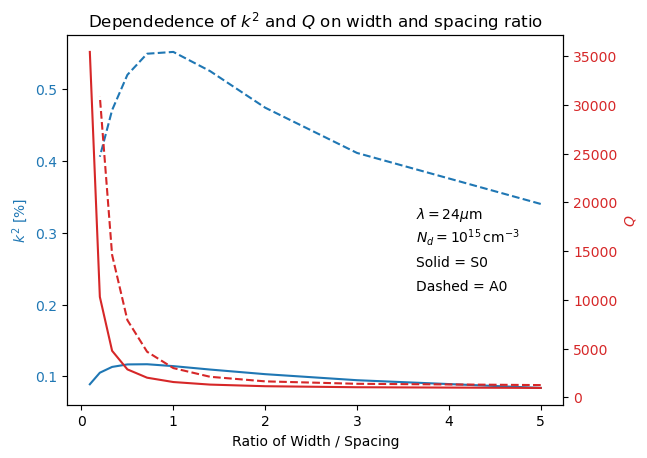

In [117]:
lambda_sel = 24.0
Nd_idx    = 1          # 1e15 cm^-3
df["lambda_um"]     = 2.0*(df["spacing_um"] + df["width_um"])
# keep only the relevant slice
dfA0 = df[(df["lambda_um"]==lambda_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["lambda_um"]==lambda_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()

# NaN/Inf guard for each plot
dfA0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
dfS0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
dfA0['w_s_ratio'] = dfA0["width_um"] / dfA0["spacing_um"]
dfS0['w_s_ratio'] = dfS0["width_um"] / dfS0["spacing_um"]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot( dfA0['w_s_ratio'], dfA0['k2_fd'], color="tab:blue")#, marker='*')
ax2.plot( dfA0['w_s_ratio'], dfA0['Q'], color = "tab:red")
ax.plot( dfS0['w_s_ratio'], dfS0['k2_fd'], color="tab:blue", linestyle='--')#,marker='o')
ax2.plot( dfS0['w_s_ratio'], dfS0['Q'], color = "tab:red", linestyle='--')
ax.annotate(r'$\lambda= 24\mu$m', xy=(0.65, 0.5), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.65, 0.45), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Dashed = A0', xy=(0.65, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.65, 0.4), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'Ratio of Width / Spacing')
ax.tick_params(axis="y", labelcolor="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax.set_title(r'Dependedence of $k^2$ and $Q$ on width and spacing ratio')
ax.set_ylabel(r'$k^2$ [%]', color="tab:blue")
ax2.set_ylabel(r'$Q$', color="tab:red")
#to do: add product of two curves on a third axis that isn't shown, but label peak value on the plot
#and / or create a new plot with same x axis, left y is k^2Q, right is fQ

In [118]:
dfA0.head()

,spacing_idx,width_idx,doping_idx,mode_idx,spacing_um,width_um,Q,freq_Hz,k2_em,k2_fd,k2_peak_spacing,lambda_um,w_s_ratio
74,0,9,1,0,2.0,10.0,964.528308,9.851481e+07,0.136894,0.083811,0.222597,24.0,5.0
146,1,8,1,0,3.0,9.0,1034.574222,9.865180e+07,0.148507,0.094561,0.214177,24.0,3.0
218,2,7,1,0,4.0,8.0,1139.297500,9.874909e+07,0.159403,0.102990,0.203355,24.0,2.0
290,3,6,1,0,5.0,7.0,1305.508170,9.880754e+07,0.170683,0.109434,0.187724,24.0,1.4
362,4,5,1,0,6.0,6.0,1568.255235,9.885847e+07,0.182833,0.114196,0.170889,24.0,1.0


Text(0.15, 0.4, 'Solid = S0')

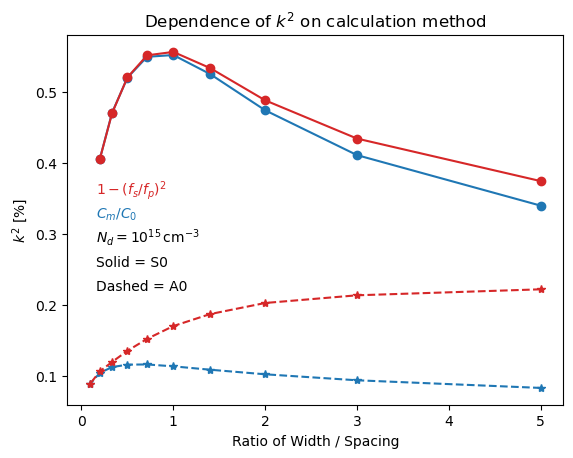

In [119]:
fig, ax = plt.subplots()

ax.plot( dfA0['w_s_ratio'], dfA0['k2_fd'], color="tab:blue", marker='*', linestyle='--')
ax.plot( dfA0['w_s_ratio'], dfA0['k2_peak_spacing'], color="tab:red", marker='*', linestyle='--')
ax.plot( dfS0['w_s_ratio'], dfS0['k2_fd'], color="tab:blue", marker='o')
ax.plot( dfS0['w_s_ratio'], dfS0['k2_peak_spacing'], color="tab:red", marker='o')
ax.set_title(r'Dependence of $k^2$ on calculation method')
ax.set_ylabel(r'$k^2$ [%]', color="k")
ax.set_xlabel(r'Ratio of Width / Spacing')
ax.annotate(r'$N_d = 10^{15} \,\text{cm}^{-3}$', xy=(0.15, 0.45), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$1-(f_s/f_p)^2$', xy=(0.15, 0.55), xycoords='figure fraction', color='tab:red', fontsize=10)
ax.annotate(r'$C_m/C_0$', xy=(0.15, 0.5), xycoords='figure fraction', color='tab:blue', fontsize=10)
ax.annotate('Dashed = A0', xy=(0.15, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.4), xycoords='figure fraction', color='k', fontsize=10)
#ax.legend()

Let's confirm the wide spread between $k^2$ calculations by replotting the measured, estimate, and fitted. Add arrows of length indicating the $k^2$ value. For peak spacing, the arrow starts and stops at the max/min frequency. The estimate actually used the peak spacing from the measured curve. 
The measured and fitted are close, but the estimate isn't very good. 
What's it mean if 